<a href="https://colab.research.google.com/github/Bryan-Az/ContrastTransferLabs/blob/main/Transfer_Learning/TL_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

github path: Transfer_Learning/TL_CV.ipynb

# Transfer Learning (TL) in Computer Vision
In this notebook, the BigTransfer (BiT) model architecture is applied and tested on the same set of data as was demonstrated in the previous supervised contrastive learning (SCL) notebook. Transfer learning is able to utilize pre-trained weights taken from different model architectures and use-cases and leverages their knowledge on a new set of data and different models architectures.

The BiT architecture is especially useful for classifying images.

BiT transfer model documentation: https://keras.io/examples/vision/bit/

## Imports

In [ ]:
! pip install -U keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from tensorflow.keras import ops
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [ ]:
print(keras.__version__)
print(tf.__version__)

3.3.3
2.15.0


## Preparing the Data
The CIFAR10 dataset does not provide a subset of images for validation, so 10% of the images will be used to create a validation set as input into the preprocessing pipelines.

In [ ]:
# Loading the keras cifar10 dataset as a tensorflow dataset
# the CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 17s 0us/step


In [ ]:
num_validation_imgs = train_images.shape[0] // 10
train_images, validation_images = train_images[num_validation_imgs:], train_images[:num_validation_imgs]
train_labels, validation_labels = train_labels[num_validation_imgs:], train_labels[:num_validation_imgs]
print(train_images.shape, validation_images.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3)


In [ ]:
# Converting the data to TensorFlow Dataset format
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))

### Visualizing a Sample of Data (Before Processing) for Basic Interpretation

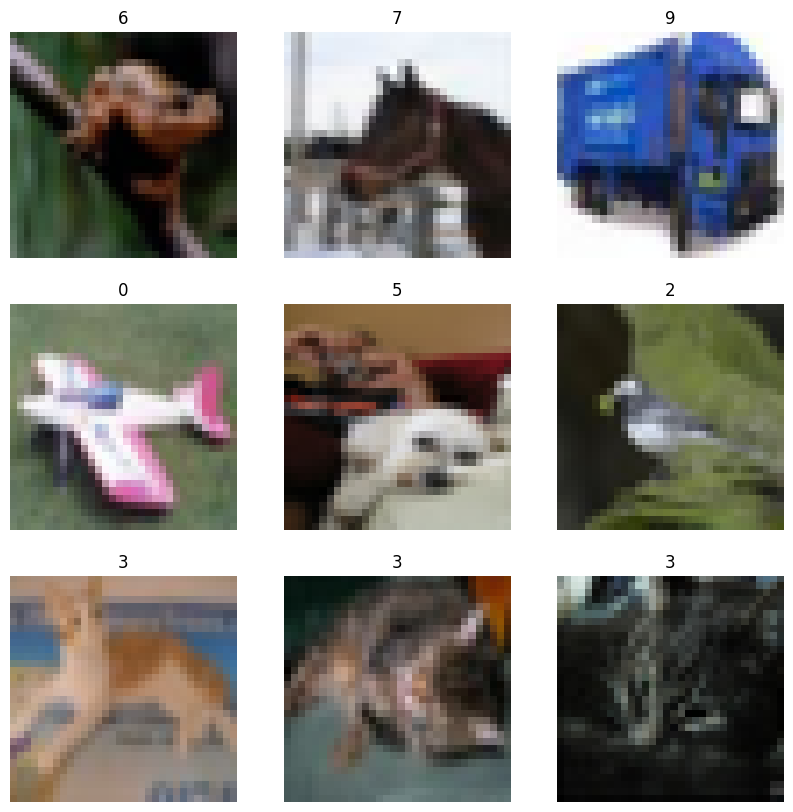

In [ ]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

It looks like the Cifar10 dataset from the tensorflow_datasets library contains images from a variety of classes - including animals, cars, boats, etc. With transfer learning, we can hope to transfer the knowledge from a larger and previously trained model to make better and more generalizable classifications on this dataset.

### Creating an Augmentation & Processing Pipeline
These pipelines are used in both training and validation and not only augment the data, but also process the image for input to the model.

In [ ]:
# Hyperparameter
SCHEDULE_BOUNDARIES = [
    200,
    300,
    400,
] # values represent the size of the data. When the input is large than these boundaries, the schedule length increases

In [ ]:
CROP_TO = 224
random_flip = keras.layers.RandomFlip("horizontal")
random_crop = keras.layers.RandomCrop(CROP_TO, CROP_TO)

def preprocess_train(image, label):
    image = random_flip(image)
    image = ops.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = random_crop(image)
    image = image / 255.0
    return (image, label)


def preprocess_test(image, label):
    image = ops.image.resize(image, (RESIZE_TO, RESIZE_TO))
    image = ops.cast(image, dtype="float32")
    image = image / 255.0
    return (image, label)

In [ ]:
# Training pipeline
DATASET_NUM_TRAIN_EXAMPLES = train_dataset.cardinality().numpy()
BATCH_SIZE = 64
RESIZE_TO = 384
STEPS_PER_EPOCH = 10
AUTO = tf.data.AUTOTUNE  # optimise the pipeline performance
# Hyperparameter
SCHEDULE_LENGTH = (
    25  # determines the length of the input images, aka. the resolution
)
repeat_count = int(
    SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH
)
repeat_count += 2 + 1  # To ensure at least there are 2 epochs of training
pipeline_train = (
    train_dataset.shuffle(10000)
    .repeat(repeat_count)  # Repeat dataset_size / num_steps
    .map(preprocess_train, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Testing pipeline
pipeline_testing = (
    test_dataset.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Validation pipeline
pipeline_validation = (
    validation_dataset.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

### Visualizing a Sample of Training Data (Post-Processing) for Basic Interpretation

The training data goes through extra augmentation steps in its' pipeline, so I want to take a peek at how they altered the images.


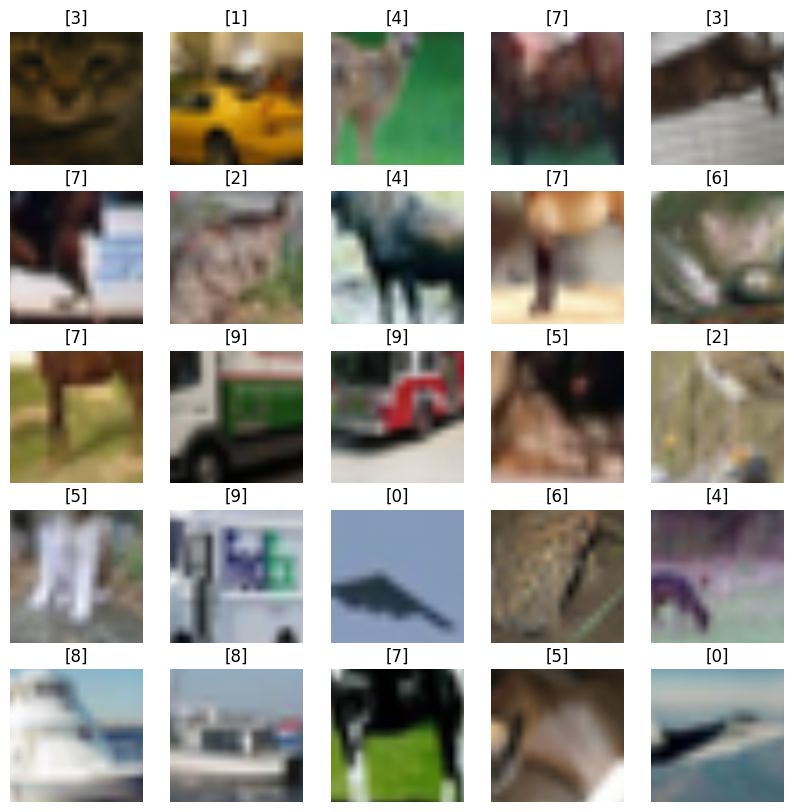

In [ ]:
image_batch, label_batch = next(iter(pipeline_train))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n].numpy())
    plt.axis("off")

## The Transfer Learning Model

In this section, the model will be defined, compiled, and trained. Also, the validation and testing metrics will be visualized to evaluate model performance.

In [ ]:
# this is the pretrained model, containing the information to be transferred
bit_model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
bit_module = hub.load(bit_model_url)

In [ ]:
# the number of unique labels in the numpy array 'validation_labels'
unique_labels = np.unique(validation_labels)
print(unique_labels)

[0 1 2 3 4 5 6 7 8 9]


In [ ]:
NUM_CLASSES = len(unique_labels)  # number of classes in the CIFAR10 dataset is 10

In [ ]:
class BiTModelTopLayers(keras.Model):
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)

        self.num_classes = num_classes
        self.head = keras.layers.Dense(num_classes, kernel_initializer="zeros")
        self.bit_model = module

    def call(self, images):
        bit_embedding = self.bit_model(images)
        return self.head(bit_embedding)

In [ ]:
transfer_model = BiTModelTopLayers(num_classes=NUM_CLASSES, module=bit_module)

These are specific parameters that can be altered accordingly to better train the model. The optimizer is the Stochastic Gradient Descent optimizer which is able to dynamically shift it's learning rate during training based on the shape of the loss surface. It also has momentum which is able to keep the optimizer moving if it ever encounters a flat surface. The loss function is Sparse Categorical Cross-Entropy which is useful when making classifications on multiple labels, typically used in combination with the Softmax activation function.

In [ ]:
learning_rate = 0.003 * BATCH_SIZE / 512

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
transfer_model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

Adding in these callbacks to the compilation of the model will help keep track of our model's performance metrics while the model is trained, for later use.

In [ ]:
train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=2, restore_best_weights=True
    )
]

### Training the Model

In [ ]:
# training the model
history = transfer_model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    epochs=int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=pipeline_validation,
    callbacks=train_callbacks,
)

Epoch 1/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 338s 32s/step - accuracy: 0.2707 - loss: 2.1157 - val_accuracy: 0.6908 - val_loss: 1.3091
Epoch 2/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 289s 29s/step - accuracy: 0.6858 - loss: 1.1415 - val_accuracy: 0.7656 - val_loss: 0.8089


### Evaluating the Model Validation and Training Metrics
Due to the large size and high dimensional nature of images, classifying them in a google colab environment with the V100 GPU instance was able to be finished in only 2 epochs. Therefore, the line plot below only shows the difference between 2 epochs.

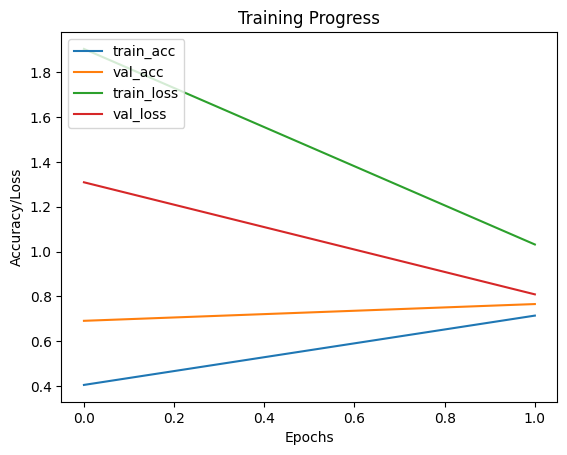

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Training Progress")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epochs")
    plt.legend(["train_acc", "val_acc", "train_loss", "val_loss"], loc="upper left")
    plt.show()


plot_hist(history)

The training progress plot shows that the training accuracy increased but did not cross over above the training loss. A better performing model would show the training loss trending closer and closer to 0 over many epochs, and the training accuracy trending towards 1.

### Evaluating the Model on the Testing Data

In [ ]:
accuracy = transfer_model.evaluate(pipeline_testing)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

157/157 ━━━━━━━━━━━━━━━━━━━━ 32s 203ms/step - accuracy: 0.7542 - loss: 0.8129
Accuracy: 75.72%


# Conclusion

The final training accuracy on the CIFAR10 dataset using the BiT transfer model, which was previously trained to classify images, showed that even with a drastically reduced image dimensionality and very low number of epochs (due to compute constraints), the model was still able to achieve ~76% accuracy on the unseen testing dataset. This is 25% better than a coin-flip accuracy and so the model is able to recognize the classes within the images with a better than random accuracy.

I believe increasing the dimensionality of the input data (which was cut-back from 500 to 25) and training epochs (cut-back from 50 to 2) would improve the model significantly, and that this transfer model architecture has shown it is able to classify images exceedingly well.